## 합성곱 신경망
### 패션 MNIST CNN

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [2]:
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

In [3]:
print(train_input.shape, test_input.shape)

(60000, 28, 28) (10000, 28, 28)


In [4]:
# 255.0 - 정규화 처리
# reshape(-1, 28, 28, 1) - 4차원 배열로 변경
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0

In [5]:
train_scaled.shape

(60000, 28, 28, 1)

In [6]:
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0

In [7]:
test_scaled.shape

(10000, 28, 28, 1)

- train_scaled에서 1차원을 더 추가한 이유
- channel 값 : 흑백이기 때문에 1채널만 있으면 됨
    - 60000(데이터 수), 28(이미지 넓이), 28(이미지 높이), 1(입력채널)

In [8]:
## 훈련세트, 검증세트 분리
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42
)

In [9]:
print(train_scaled.shape, val_scaled.shape)
print(train_target.shape, val_target.shape)

(48000, 28, 28, 1) (12000, 28, 28, 1)
(48000,) (12000,)


### 합성곱 신경망 만들기

In [10]:
model = keras.Sequential(name='CNN1')

# 32 -> 합성곱 층의 필터 개수
# kernel_size = 3 -> (3x3)
# padding, same -> 패딩 추가해서 특성맵사이즈를 원본과 동일하게
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28, 28, 1)))

In [11]:
model.summary()

Model: "CNN1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
Total params: 320 (1.25 KB)
Trainable params: 320 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
model.add(keras.layers.MaxPooling2D(2)) # 특성맵이 반으로 줄어듦. 4x14 사이즈의 특성맵

In [13]:
model.summary()

Model: "CNN1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
Total params: 320 (1.25 KB)
Trainable params: 320 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# 두번째 합성곱/풀링층 추가
model.add(keras.layers.Conv2D(54, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2)) # 사이즈 반으로, 7x7x64 사이즈의 특성맵 -> 3136 출력

In [15]:
# 심층신경망을 붙임
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))

#### 위에 학습을 위해서 나눠놓은 것
- 아래에 다시 하나의 셀에 합침

In [16]:
model = keras.Sequential(name='CNN1')

# 32 -> 합성곱 층의 필터 개수
# kernel_size = 3 -> (3x3)
# padding, same -> 패딩 추가해서 특성맵사이즈를 원본과 동일하게
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28, 28, 1), name='First_CNN'))

# 두번째 합성곱/풀링층 추가
model.add(keras.layers.Conv2D(54, kernel_size=3, activation='relu', padding='same', name='Second_CNN'))
model.add(keras.layers.MaxPooling2D(2)) # 사이즈 반으로, 7x7x64 사이즈의 특성맵 -> 3136 출력

# 심층신경망을 붙임
model.add(keras.layers.Flatten(name='Flatten'))
model.add(keras.layers.Dense(100, activation='relu', name='Hidden'))
model.add(keras.layers.Dropout(0.4, name='Dropout'))
model.add(keras.layers.Dense(10, activation='softmax', name='Output'))

In [17]:
model.summary()

Model: "CNN1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 First_CNN (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 Second_CNN (Conv2D)         (None, 28, 28, 54)        15606     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 54)        0         
 g2D)                                                            
                                                                 
 Flatten (Flatten)           (None, 10584)             0         
                                                                 
 Hidden (Dense)              (None, 100)               1058500   
                                                                 
 Dropout (Dropout)           (None, 100)               0         
                                                              

- graphviz 설치
- pydot 파이썬 모듈 설치
- VSCode 재시작

In [18]:
!pip install pydot


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


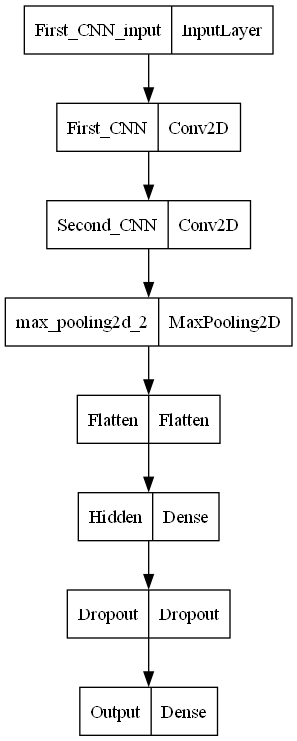

In [19]:
# 모델 시각화
keras.utils.plot_model(model)

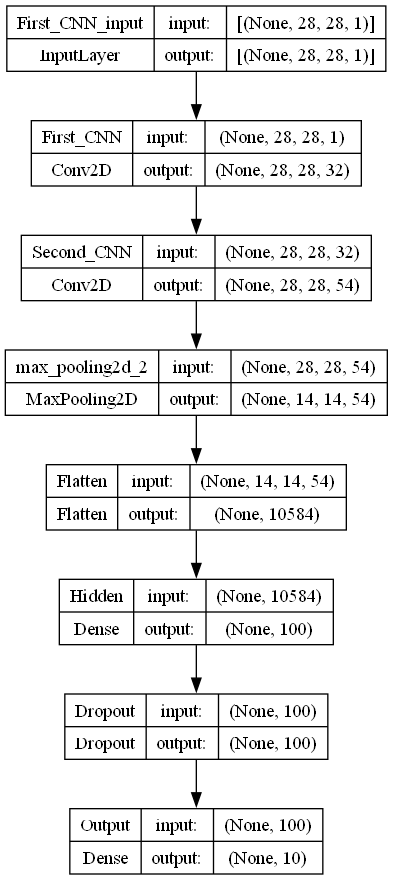

In [20]:
## 상세 모델 시각화
keras.utils.plot_model(model, show_shapes=True)

#### 모델 컴파일, 훈련

In [21]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

In [22]:
# 모델 훈련
history = model.fit(train_scaled, train_target, epochs=50, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50


1500/1500 [==============================] - 32s 20ms/step - loss: 0.4608 - accuracy: 0.8389 - val_loss: 0.2974 - val_accuracy: 0.8911
Epoch 2/50
   4/1500 [..............................] - ETA: 31s - loss: 0.2137 - accuracy: 0.9297

c:\Source\iot-dataanalysis-2025\mlvenv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1500/1500 [==============================] - 31s 21ms/step - loss: 0.2984 - accuracy: 0.8923 - val_loss: 0.2493 - val_accuracy: 0.9072
Epoch 3/50
1500/1500 [==============================] - 32s 21ms/step - loss: 0.2519 - accuracy: 0.9067 - val_loss: 0.2386 - val_accuracy: 0.9094
Epoch 4/50
1500/1500 [==============================] - 32s 21ms/step - loss: 0.2149 - accuracy: 0.9212 - val_loss: 0.2284 - val_accuracy: 0.9137
Epoch 5/50
1500/1500 [==============================] - 34s 22ms/step - loss: 0.1875 - accuracy: 0.9311 - val_loss: 0.2255 - val_accuracy: 0.9210
Epoch 6/50
1500/1500 [==============================] - 31s 21ms/step - loss: 0.1604 - accuracy: 0.9395 - val_loss: 0.2147 - val_accuracy: 0.9233
Epoch 7/50
1500/1500 [==============================] - 32s 21ms/step - loss: 0.1441 - accuracy: 0.9459 - val_loss: 0.2184 - val_accuracy: 0.9241
Epoch 8/50
1500/1500 [==============================] - 32s 21ms/step - loss: 0.1262 - accuracy: 0.9511 - val_loss: 0.2384 - val_accura

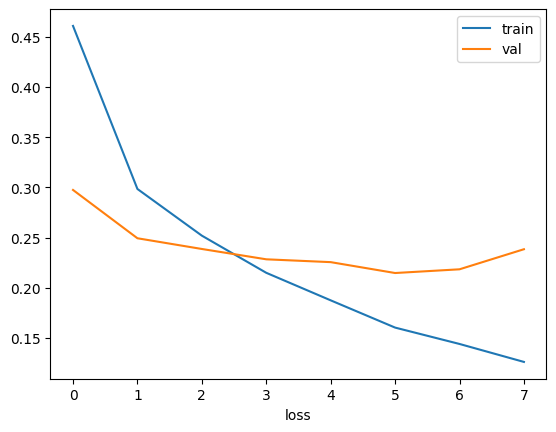

In [23]:
# 정확도 확인
import matplotlib.pylab as plt
 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.xlabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [24]:
# 모델 검증 정확도
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 2s 4ms/step - loss: 0.2147 - accuracy: 0.9233


[0.214702308177948, 0.9232500195503235]

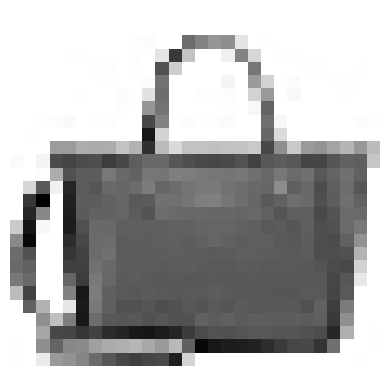

In [25]:
# val_scaled[0]
plt.imshow(val_scaled[0].reshape(28,28), cmap='gray_r')
plt.axis('off')
plt.show()

In [26]:
model.predict(val_scaled[0:1]).round(3)

1/1 [==============================] - 0s 76ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

예측 시각화

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [28]:
# 한글로 Matplotlib 사용시 항상 필요
from matplotlib import rcParams, font_manager, rc

font_path = 'C:/Windows/Fonts/malgun.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
rcParams['axes.unicode_minus'] = False

sns.set_style('darkgrid')
sns.set_theme(font='Malgun Gothic', rc={'axes.unicode_minus': False})

In [29]:
class_names = ['티셔츠', '바지', '스웨터', '드레스', '코트', '샌달', '셔츠', '스니커즈', '가방', '앵클부츠']

In [30]:
pred_result = model.predict(test_scaled)

313/313 [==============================] - 1s 4ms/step


In [31]:
# 테스트이미지와 예측결과 시각화
def show_image(index):
    plt.figure(figsize=(2,2))
    plt.imshow(test_input[index].reshape(28, 28), cmap='gray_r')
    true_label = class_names[test_target[index]]
    pred_label = class_names[np.argmax(pred_result[index])]

    #plt.title(f'실제: {true_label}, 예측: {pred_label}')
    plt.text(0, -6, f'실제: {true_label}', fontsize=12, color='blue')
    plt.text(0, -3, f'예측: {pred_label}', fontsize=12, color='red', fontweight='bold')

    plt.axis('off')
    plt.show()

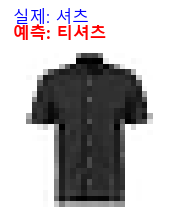

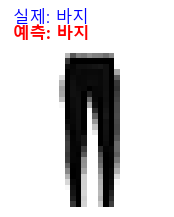

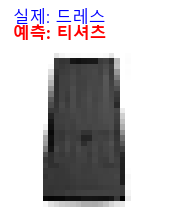

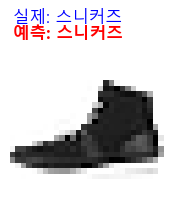

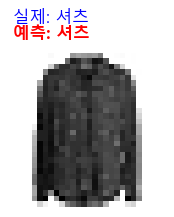

In [32]:
for i in range(40,45):
    show_image(i)

In [33]:
## 테스트세트로 검증
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 1s 4ms/step - loss: 0.2341 - accuracy: 0.9206


[0.23405854403972626, 0.9205999970436096]

#### 저장한 모델 로드

In [34]:
model2 = keras.models.load_model('./best-cnn-model.h5')

In [35]:
model2.layers

In [36]:
model2.summary()

Model: "CNN1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 First_CNN (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 Second_CNN (Conv2D)         (None, 28, 28, 54)        15606     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 54)        0         
 g2D)                                                            
                                                                 
 Flatten (Flatten)           (None, 10584)             0         
                                                                 
 Hidden (Dense)              (None, 100)               1058500   
                                                                 
 Dropout (Dropout)           (None, 100)               0         
                                                              

In [37]:
# 모델 입력값 확인
model2.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'First_CNN_input')>

In [38]:
model2.layers[0].output

<KerasTensor: shape=(None, 28, 28, 32) dtype=float32 (created by layer 'First_CNN')>

#### 특성맵 시각화

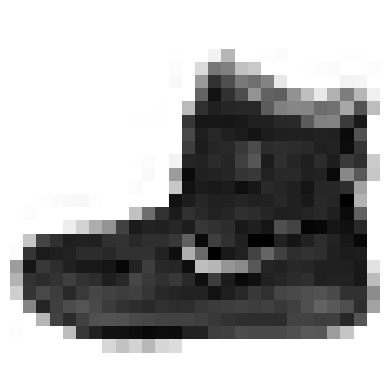

In [39]:
plt.imshow(train_input[0], cmap='gray_r')
plt.axis('off')
plt.show()

In [41]:
# 전체 모델에서 첫번째 합성곱레이어만 떼서 모델로 생성
model2_first_layer = keras.Model(model2.input, model2.layers[0].output)

In [42]:
model2_first_layer.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 First_CNN_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 First_CNN (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
Total params: 320 (1.25 KB)
Trainable params: 320 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
# 훈련세트 1번째 앵클부츠로 특성맵 생성
inputs = train_input[0:1].reshape(-1, 28, 28, 1) / 255.0
feature_maps = model2_first_layer.predict(inputs)

1/1 [==============================] - 0s 36ms/step


In [44]:
feature_maps.shape

(1, 28, 28, 32)

- matplotlib colormap : https://matplotlib.org/stable/users/explain/colors/colormaps.html

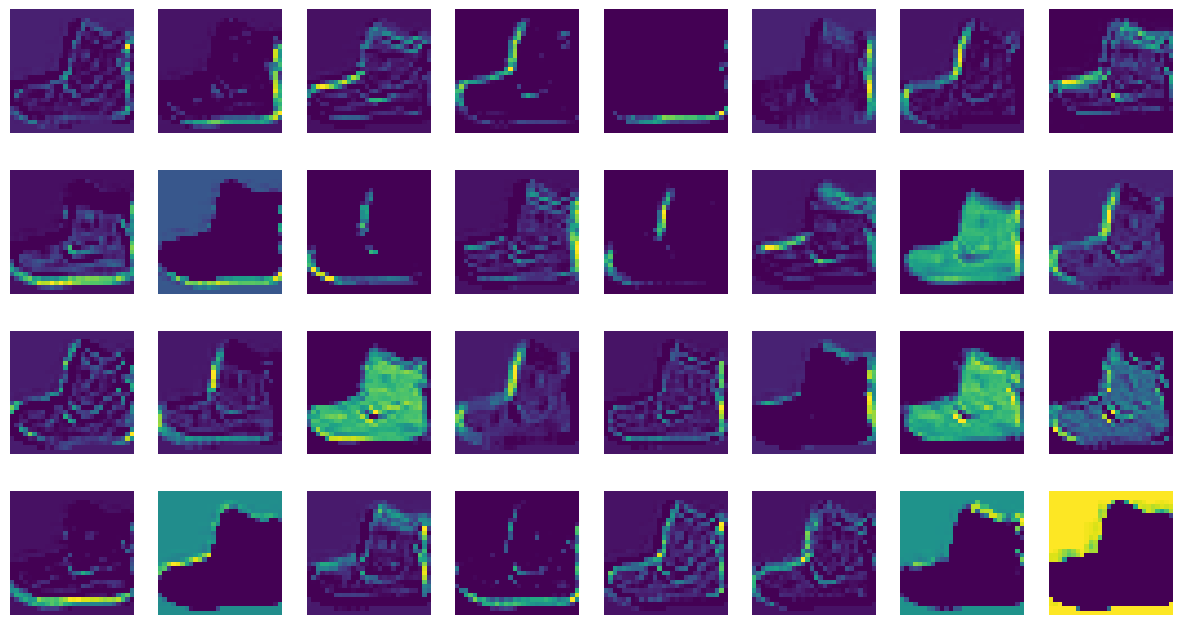

In [45]:
fig, axs = plt.subplots(4, 8, figsize=(15, 8))
for i in range(4):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0, :, :, i*8 + j], cmap='viridis')
        axs[i, j].axis('off')

plt.show()

- 위는 첫번째 합성곱을 통과한 앵클부츠의 결과화면

#### 결론
- 일반신경망이나 심층신경망으로 훈련했을 때 보다 정확도가 높아짐
- 심층신경망 : 대락 88%
- `합성곱신경망` : 대략 92%

##### 머신러닝/딥러닝 프레임워크 종류
- 사이킷 런 : 머신러닝에 특화된 프레임워크
    - 몇몇 기능은 다른 프레임워크에 없어서 같이 사용 중
- 텐서플로/케라스 : 구글 개발 머신러닝 프레임 워크
- 파이토치 : 페이스북(메타) 개발 머신러닝 프레임워크
- fastai : 파이토치 기반으로 된 딥러닝 프레임워크
- JAX : 구글 개발 최첨단 연구용 딥러닝 프레임워크
- MXNet : 아마존 개발